In [78]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from pprint import pprint

In [79]:
%load_ext autoreload
%autoreload 1
%aimport main
%aimport data_utils
%aimport contrastive_data
%aimport models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
from contrastive_data import *
from data_utils import *
from main import *
from models import *

# Data and model

In [81]:
data_path = '/home/lguirardel/data/perturb_comp/data/TP53/'

In [82]:
paths = get_paths(data_path)
counts = load_data(*paths, group_wt_like=True)

	Reading files...


	Merging and processing...
		Grouping WT-like variants.
		75 variant classes


Run from here to re-split without reloading all data (will be necessary if wtlike is changed however)

In [155]:
run_name = 'TP53_015'
dir_name = join('models',run_name)
! cat models/{run_name}/config.ini

alpha = 0.0
dropout = 0.5
weight-decay = 0.01
batch-size = 256
loss = standard
margin = 1
lr = 0.001
n-epochs = 10000
shape = [100, 100]
embed-dim = 20
n-workers = 4


In [156]:
df_train, df_seen, df_unseen = load_split(join(dir_name, 'split'), counts, )
df_dict = {
    'train':df_train,
    'seen':df_seen,
    'unseen':df_unseen,
}

In [157]:
dl_train, dl_seen, dl_unseen = make_loaders(
    df_train, df_seen,df_unseen, batch_size=64, dataset_class=SiameseDataset,n_workers=1,pos_frac=0.5)

In [158]:
model = torch.load(join(dir_name,'model.pkl'), map_location='cpu')
# model = torch.load(join(dir_name,'best_model.pkl'), map_location='cpu')

In [159]:
model

Siamese(
  (network): MLP(
    (layers): Sequential(
      (0): Linear(in_features=1224, out_features=100, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): ELU(alpha=1.0)
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=100, out_features=20, bias=True)
    )
  )
)

# PCA

In [160]:
X = torch.tensor(df_train.drop(columns=['variant','Variant functional class']).to_numpy(), dtype=torch.float32)
embeds = []
for i,x in enumerate(X):
    with torch.no_grad():
        embeds.append(model.network.forward(x))
embeds = torch.stack(embeds)
pca = PCA(2).fit(embeds)


# Embedding distribution

In [161]:
make_dir_if_needed(f'plots/embeds/{run_name}')

In [162]:
subset = 'train'
df = df_train

X = torch.tensor(df.drop(columns=['variant','Variant functional class']).to_numpy(), dtype=torch.float32)
embeds = []
for i,x in enumerate(X):
    with torch.no_grad():
        embeds.append(model.network.forward(x))
embeds = torch.stack(embeds)

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

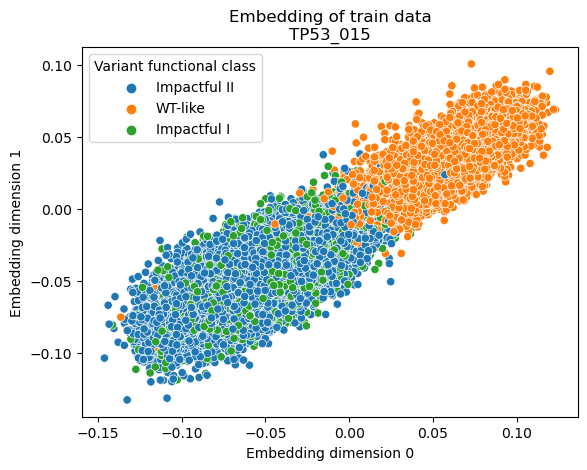

In [163]:
i,j = 0,1
sns.scatterplot(x=embeds[:,i], y=embeds[:,j], hue = df['Variant functional class'])
plt.xlabel(f'Embedding dimension {i}')
plt.ylabel(f'Embedding dimension {j}')
plt.title(f'Embedding of {subset} data\n{run_name}')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_{i}_{j}_scatter.pdf')

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

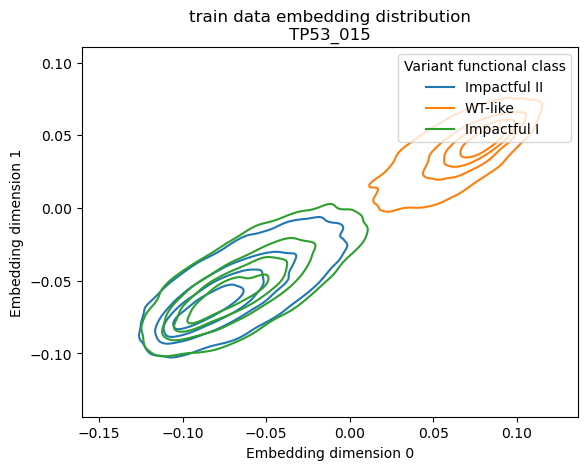

In [164]:
# sns.kdeplot(x=embeds[:,i], y=embeds[:,j], hue = df['Variant functional class'], levels=5, common_norm=False)
# plt.xlabel(f'Embedding dimension {i}')
# plt.ylabel(f'Embedding dimension {j}')
# plt.title(f'{subset} data embedding distribution\n{run_name}')
# plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_{i}_{j}_kde.pdf')

Explained variance : 98.2 %


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

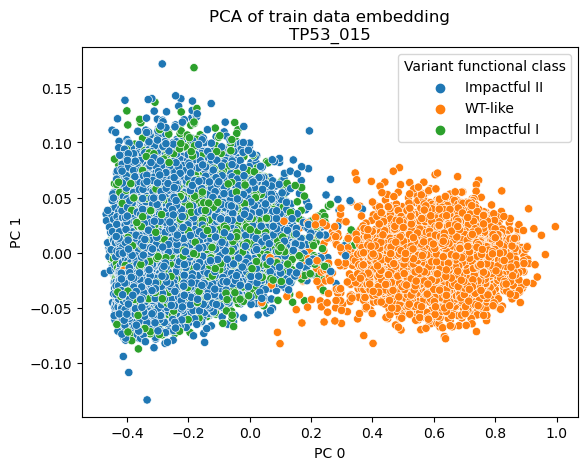

In [165]:
emb_red = pca.transform(embeds)
print(f'Explained variance : {(pca.explained_variance_ratio_).sum()*100:.1f} %')
sns.scatterplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'])
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding\n{run_name}')
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_scatter.pdf')

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

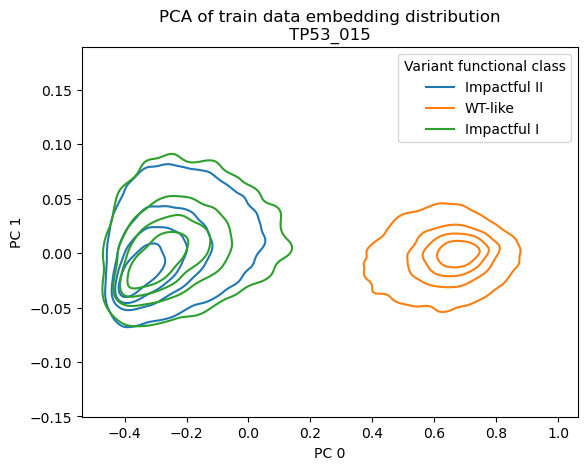

In [166]:
sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], levels=5, common_norm=False)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_embed_pca_kde.pdf')

In [167]:
df[df['Variant functional class'] == 'Impactful I'].variant.unique()

array(['M246V', 'R158H', 'S241C', 'R337L', 'R273L', 'R273C', 'R273H',
       'unassigned', 'K132R', 'M237I', 'P152L'], dtype=object)

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

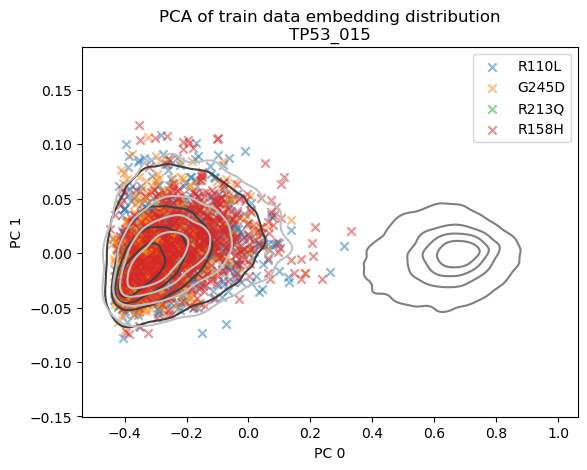

In [168]:
# variants = ['R110L', 'G245D', 'R213Q','R158H']


# sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['Variant functional class'], levels=5, common_norm=False, legend=False,palette='gray')
# plt.xlabel(f'PC 0')
# plt.ylabel(f'PC 1')
# plt.title(f'PCA of {subset} data embedding distribution\n{run_name}' )
# for v in variants:
#     idx = (df['variant'] == v).to_numpy()
#     plt.scatter(x=emb_red[idx,0], y=emb_red[idx,1],label=v, marker='x',alpha=0.5)
# plt.legend()

# Scores

## Intra-group

In [126]:
subset = 'train'
group = 'Impactful II'
df = df_train

df = df[df['Variant functional class'] == group]

X = torch.tensor(df.drop(columns=['variant','Variant functional class']).to_numpy(), dtype=torch.float32)
embeds = []
for i,x in enumerate(X):
    with torch.no_grad():
        embeds.append(model.network.forward(x))
embeds = torch.stack(embeds)

emb_red = pca.transform(embeds)


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

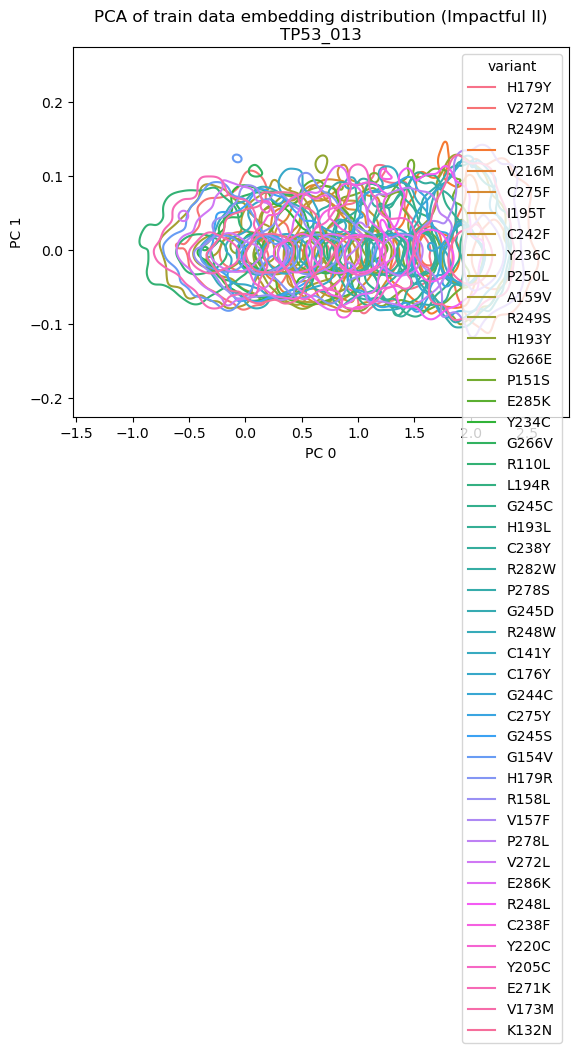

In [127]:
sns.kdeplot(x=emb_red[:,0], y=emb_red[:,1], hue = df['variant'], levels=3, common_norm=False)
plt.xlabel(f'PC 0')
plt.ylabel(f'PC 1')
plt.title(f'PCA of {subset} data embedding distribution ({group})\n{run_name}' )
plt.savefig(f'plots/embeds/{run_name}/{subset}_{group}_embed_pca_kde.pdf')

In [128]:
dl = DataLoader(SiameseDataset(df, p=0.5), batch_size=64, shuffle=True)
metrics = test_loop(dl, model, SiameseLoss(margin=1, alpha=0), device='cpu', margin=1)
print(f'Metrics for {subset} data, {group=}')
pprint(metrics)

Metrics for train data, group='Impactful II'
{'dist_neg': 0.8787398934364319,
 'dist_pos': 0.19465377926826477,
 'l2_penalty': 0.0,
 'loss': 0.13738484145142138,
 'roc': 0.8755230903625488}


## Inter-group

En chantier - je pense que ça fait plus de sens avec une metrique 1-nn que avec la ROC 

In [152]:
subset = 'train'
group1 = 'Impactful I'
group2 = 'Impactful II'
df = df_train

df1 = df[df['Variant functional class'] == group1]
df2 = df[df['Variant functional class'] == group2]


In [153]:
dl = DataLoader(
    BipartiteDataset(df1, df2, p1=0.5), # will always get 
    batch_size=64, shuffle=True,
)

In [154]:
metrics = test_loop(dl, model, SiameseLoss(margin=1, alpha=0), device='cpu', margin=1)
print(f'Metrics for {subset} data, {group1=}, {group2=}')
pprint(metrics)

Metrics for train data, group1='Impactful I', group2='Impactful II'
{'_n_neg': 3410,
 '_n_pos': 3353,
 'dist_neg': 1.4901349544525146,
 'dist_pos': 0.20445066690444946,
 'l2_penalty': 0.0,
 'loss': 0.06948248616788748,
 'roc': 0.9615837931632996}


# Training

In [169]:
from tensorboard.backend.event_processing import event_accumulator

In [170]:
ea = event_accumulator.EventAccumulator(f'runs/{run_name}')

## Checking score

In [171]:
metrics = test_loop(dl_seen, model, SiameseLoss(margin=1, alpha=0), device='cpu', margin=1)
pprint(metrics)

{'_n_neg': 8537,
 '_n_pos': 8450,
 'dist_neg': 0.35183823108673096,
 'dist_pos': 0.3237740695476532,
 'l2_penalty': 0.0,
 'loss': 0.3172447245596047,
 'roc': 0.530867338180542}


## Plotting training curves

In [172]:
make_dir_if_needed('plots/runs')

In [173]:
ea.Reload()

In [174]:
ea.scalars.Keys()

['train/dist_pos',
 'train/dist_neg',
 'train/l2_penalty',
 'train/loss',
 'train/roc',
 'test_seen/dist_pos',
 'test_seen/dist_neg',
 'test_seen/l2_penalty',
 'test_seen/loss',
 'test_seen/roc',
 'test_unseen/dist_pos',
 'test_unseen/dist_neg',
 'test_unseen/l2_penalty',
 'test_unseen/loss',
 'test_unseen/roc']

In [175]:
# def get_df_from_tb(ea:event_accumulator.EventAccumulator, keys:List[str]=None) :
#     df = pd.DataFrame()
#     if keys is None:
#         keys = ea.scalars.Keys()
#     for key in keys:
#         events = ea.scalars.Items(key)
#         df[key] = pd.Series(data=[e.value for e in events], index=[e.step for e in events])
#     return df

In [176]:
def get_df_from_tb(ea:event_accumulator.EventAccumulator, keys:List[str]=None) :
    df = []
    if keys is None:
        keys = ea.scalars.Keys()
    for key in keys:
        events = ea.scalars.Items(key)
        for e in events:
            df.append({'value':e.value, 'epoch':e.step,'scalar':key})
    return pd.DataFrame.from_records(df)

In [177]:
df = get_df_from_tb(ea, ['train/loss', 'train/roc','test_seen/loss','test_seen/roc'])

In [178]:
df

,value,epoch,scalar
0,0.361766,0,train/loss
1,0.259049,1,train/loss
2,0.259473,2,train/loss
3,0.259760,3,train/loss
4,0.258866,4,train/loss
...,...,...,...
4347,0.535390,1083,test_seen/roc
4348,0.531261,1084,test_seen/roc
4349,0.528949,1085,test_seen/roc
4350,0.535964,1086,test_seen/roc


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

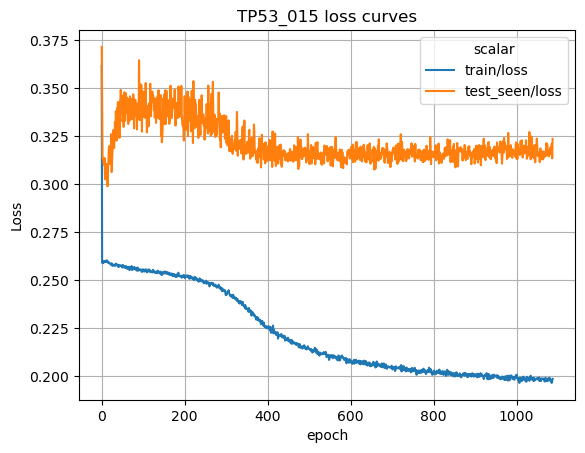

In [179]:
sns.lineplot(df[df.scalar.isin(['train/loss', 'test_seen/loss'])], x='epoch',y='value',hue='scalar')
plt.title(f'{run_name} loss curves')
plt.ylabel('Loss')
# plt.yscale('logit')
plt.savefig(f'plots/runs/{run_name}_loss.pdf')
plt.grid()
